In [34]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import os
import pickle

In [35]:
# Configurations
save_stats = False
save_figs = False

## 2. Q-Learning

In [2]:
def measure_performance(player_1, player_2, num_episodes = 500):
    """
    Measures performance of player 1 against player 2 (percentage of wins player 1)
    TODO
    """
    meas = 0
    turns = np.array(['X','O'])
    env = TictactoeEnv()
    for itr in range(num_episodes):
        env.reset()
        grid, _, __ = env.observe()
        player_1.set_player(turns[itr%2])
        player_2.set_player(turns[(itr+1)%2])
        while not env.end:
            if env.current_player == player_1.player:
                move = player_1.act(grid)
            else:
                move = player_2.act(grid)
            grid, _, _ = env.step(move, print_grid=False)
        meas += env.reward(player=player_1.player)
    return meas/num_episodes

def running_average(vec, windows_size = 250):
    idx = np.arange(0,len(vec),windows_size)
    return [np.sum(vec[i:i+windows_size])/windows_size for i in idx], idx + windows_size

def encode_state(state):
    return state.tobytes()

def available(grid):
    """
    TODO
    """
    avail_indices = []
    avail_mask = [False] * 9
    for i in range(9):
        pos = (int(i/3), i % 3)
        if grid[pos] == 0:
            avail_indices.append(i)
            avail_mask[i] = True
    return avail_indices, avail_mask

def epsilon_greedy_action(grid, Q, epsilon, num_actions = 9):
    """
    TODO
    """
    avail_indices, avail_mask = available(grid)

    if np.random.uniform(0,1) < epsilon:
        return avail_indices[np.random.randint(0, len(avail_indices))]
    else:
        q = Q[encode_state(grid)]
        q[np.logical_not(avail_mask)] = np.nan
        max_indices = np.argwhere(q == np.nanmax(q))
        return int(max_indices[np.random.randint(0, len(max_indices))])

class QPlayer:
    """
    TODO
    """
    def __init__(self, Q, player='X'):
        self.Q = Q
        self.player = player  # 'x' or 'O'

    def set_player(self, player='X', j=-1):
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def act(self, grid, **kwargs):
        """
        TODO
        """
        return epsilon_greedy_action(grid, self.Q, 0)


def q_learning(env, alpha = 0.5, gamma = 0.99, num_episodes = 20000, epsilon_exploration = 0.1, epsilon_exploration_rule = None, epsilon_opt = 0.5, test_freq = None, verbose = False):
    """
    TODO
    """
    turns = np.array(['X','O'])
    # Q-values map
    # Dictionary that maps the np.ndarray.tobyte() representation of the grid to an array of action values
    Q = defaultdict(lambda: np.zeros(9))    # All Q-values are initialized to 0
    # Stats of training
    episode_rewards = np.zeros(num_episodes)
    episode_Mopt = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
    episode_Mrand = [measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))]
    if verbose:
                print('Episode  0 :\tM_opt = ', episode_Mopt[0], '\tM_rand = ', episode_Mrand[0])
    # Rule for exploration
    if epsilon_exploration_rule is None:
        def epsilon_exploration_rule(n):
            return epsilon_exploration

    for itr in range(num_episodes):
        my_player = turns[itr % 2]
        player_opt = OptimalPlayer(epsilon=epsilon_opt, player=turns[(itr+1) % 2])
        env.reset()
        state, _, _ = env.observe()
        # First step of the adversarial
        if env.current_player == player_opt.player:
            move = player_opt.act(state)
            state, _, _ = env.step(move)
        action = epsilon_greedy_action(state, Q, epsilon_exploration_rule(itr+1))
        while not env.end:
            next_state, _, _ = env.step(action)     # Move according to the policy
            if not env.end:
                move = player_opt.act(next_state)   # Adversarial move
                next_state, _, _ = env.step(move)
            # Sarsa update rule
            reward = env.reward(player=my_player)
            if not env.end:
                next_action = epsilon_greedy_action(next_state, Q, epsilon_exploration_rule(itr+1))
                target = reward + gamma * Q[encode_state(next_state)][next_action]
            else:
                target = reward
            Q[encode_state(state)][action] += alpha * (target - Q[encode_state(state)][action])
            # Preparing for the next move
            episode_rewards[itr] = reward
            state = next_state
            action = next_action
        # Testing the performance
        if (test_freq is not None) and ((itr+1)%test_freq == 0):
            M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
            M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
            episode_Mopt.append(M_opt)
            episode_Mrand.append(M_rand)
            if verbose:
                print('Episode ', itr+1, ':\tM_opt = ', M_opt, '\tM_rand = ', M_rand)
    # Dictionary of stats
    stats = {
        'rewards': episode_rewards,
        'test_Mopt': episode_Mopt,
        'test_Mrand': episode_Mrand,
    }
    return Q, stats

### 2.1 Learning from experts

In [12]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000
epsilon_exploration = 0.01

Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration)

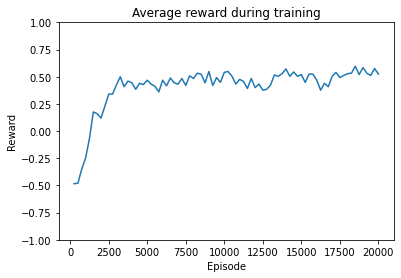


----- Optimal  player-----
M_opt =  0.0
M_rand =  0.924

----- Random  player-----
M_opt =  -0.924
M_rand =  0.068

----- Trained  player-----
M_opt =  0.0
M_rand =  0.826


In [13]:
# Plotting the average reward for every 250 games during training
running_average_rewards, x = running_average(stats['rewards'])
plt.plot(x, running_average_rewards)
plt.ylim([-1,1])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average reward during training')
plt.show()

# Comparing the performance with the optimal player and the random player
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.)
player_rand = OptimalPlayer(epsilon=1.)

names = ['Optimal', 'Random', 'Trained']
players = [OptimalPlayer(epsilon=0.), OptimalPlayer(epsilon=1.), QPlayer(Q=Q)]

for (name, player) in zip(names, players):
    print("\n-----", name, " player-----")
    m_opt = measure_performance(player, player_opt)
    print("M_opt = ", m_opt)
    m_rand = measure_performance(player, player_rand)
    print("M_rand = ", m_rand)

#### 2.1.1 Decreasing exploration

In [36]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
print(vec_n_star)
stats_dict_nstar = {}
for n_star in vec_n_star:
    print("------------- Training with n_star =", n_star, "-------------")
    def epsilon_exploration_rule(n):
        return np.max([epsilon_min, epsilon_max * (1 - n/n_star)])
    start = time.time()
    Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, test_freq=test_freq)
    M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
    M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict_nstar.update({n_star: (stats, M_opt, M_rand)})
    elapsed = time.time() - start
    print("Training with n_star =", n_star, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))


if save_stats:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar, handle, protocol=pickle.HIGHEST_PROTOCOL)

[1.0000e+00 1.0000e+02 5.0000e+02 7.5000e+02 1.0000e+03 1.2790e+03
 1.6350e+03 2.0910e+03 2.6740e+03 3.4200e+03 4.3730e+03 5.5930e+03
 7.1520e+03 9.1460e+03 1.1696e+04 1.4957e+04 1.9127e+04 2.4460e+04
 3.1279e+04 4.0000e+04]
------------- Training with n_star = 1.0 -------------
M_opt = 0.0
M_rand = 0.6875
Training with n_star = 1.0  took: 00h03m16s
------------- Training with n_star = 100.0 -------------
M_opt = 0.0
M_rand = 0.8435
Training with n_star = 100.0  took: 00h03m04s
------------- Training with n_star = 500.0 -------------
M_opt = 0.0
M_rand = 0.768
Training with n_star = 500.0  took: 00h03m09s
------------- Training with n_star = 750.0 -------------
M_opt = 0.0
M_rand = 0.854
Training with n_star = 750.0  took: 00h03m01s
------------- Training with n_star = 1000.0 -------------
M_opt = 0.0
M_rand = 0.789
Training with n_star = 1000.0  took: 00h03m00s
------------- Training with n_star = 1279.0 -------------
M_opt = 0.0
M_rand = 0.7635
Training with n_star = 1279.0  took: 00

In [37]:
def plot_stats(stats_dict, vec_var, var_name, var_legend_name, save = False):
    fig_reward, ax_reward = plt.subplots()
    fig_performance, ax = plt.subplots(1,2, figsize=(13.4,4.8))

    for var in vec_var:
        (stats, M_opt, M_rand) = stats_dict[var]
        # Plot of the average reward during training
        running_average_rewards, x_reward = running_average(stats['rewards'])
        ax_reward.plot(x_reward, running_average_rewards, label="$"+ var_legend_name +" = "+ str(var) +"$")
        # Plot of M_opt and M_rand during training
        x_performance = np.arange(0, len(stats['rewards'])+1, len(stats['rewards']) / (len(stats['test_Mopt']) - 1))
        ax[0].plot(x_performance, stats['test_Mopt'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        ax[1].plot(x_performance, stats['test_Mrand'], label="$"+ var_legend_name +" = "+ str(var) +"$")
        print(var_name + " =", var,": \tM_opt = ", M_opt, "\tM_rand = ", M_rand)

    ax_reward.set_ylim([-1,1])
    ax_reward.set_xlabel('Episode')
    ax_reward.set_ylabel('Reward')
    ax_reward.set_title('Average reward during training')
    ax_reward.legend(loc='lower right')


    ax[0].hlines(y=0, xmin=x[0], xmax=x[-1], color='r', linestyle='--')
    ax[0].set_ylim([-1,0.1])
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('$M_{opt}$')
    ax[0].set_title('$M_{opt}$ during training')
    ax[0].legend(loc='lower right')

    ax[1].set_ylim([-1,1])
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('$M_{rand}$')
    ax[1].set_title('$M_{rand}$ during training')
    ax[1].legend(loc='lower right')
    plt.show()
    if save:
        output_folder = os.path.join(os.getcwd(), 'figures')
        os.makedirs(output_folder, exist_ok=True)
        fig_performance.savefig(output_folder + '/performance_'+var_name+'.png')
        fig_reward.savefig(output_folder + '/rewards_'+var_name+'.png')

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.6875
n_star = 100.0 : 	M_opt =  0.0 	M_rand =  0.8435
n_star = 500.0 : 	M_opt =  0.0 	M_rand =  0.768
n_star = 750.0 : 	M_opt =  0.0 	M_rand =  0.854
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.789
n_star = 1279.0 : 	M_opt =  0.0 	M_rand =  0.7635
n_star = 1635.0 : 	M_opt =  -0.202 	M_rand =  0.7655
n_star = 2091.0 : 	M_opt =  -0.2905 	M_rand =  0.7275
n_star = 2674.0 : 	M_opt =  -0.1045 	M_rand =  0.773
n_star = 3420.0 : 	M_opt =  -0.109 	M_rand =  0.8235
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.7895
n_star = 5593.0 : 	M_opt =  -0.1945 	M_rand =  0.8
n_star = 7152.0 : 	M_opt =  -0.102 	M_rand =  0.706
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.7965
n_star = 11696.0 : 	M_opt =  -0.1015 	M_rand =  0.782
n_star = 14957.0 : 	M_opt =  -0.117 	M_rand =  0.7815
n_star = 19127.0 : 	M_opt =  -0.0945 	M_rand =  0.807
n_star = 24460.0 : 	M_opt =  -0.0915 	M_rand =  0.754
n_star = 31279.0 : 	M_opt =  -0.298 	M_rand =  0.6775
n_star = 40000.0 : 	M_o

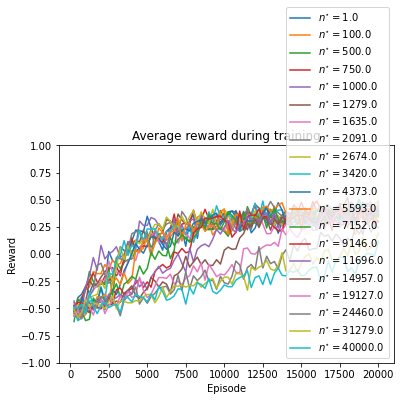

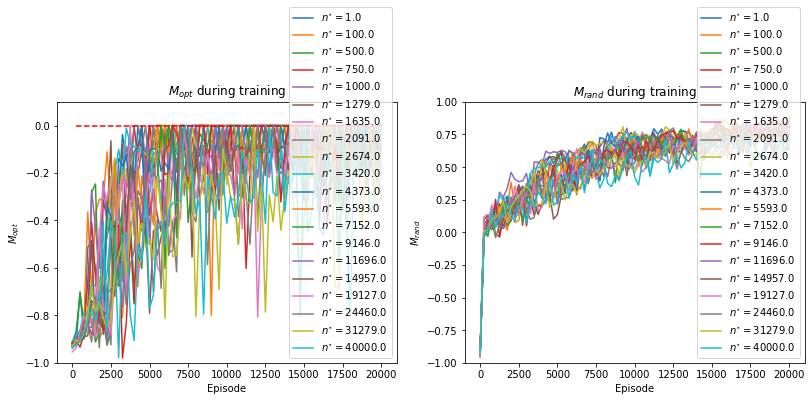

In [38]:
plot_n_star = vec_n_star
plot_stats(stats_dict_nstar, plot_n_star, 'n_star', "n^{\star}", save=save_figs)

#### 2.1.2 Good experts and bad experts

In [30]:
n_star = 4000
#vec_epsilon_opt = [0, 0.3, 0.5, 0.7, 1]
vec_epsilon_opt = [0, bohvediamocosainserire, 1]
stats_dict_epsilon_opt = {}
for epsilon_opt in vec_epsilon_opt:
    print("------------- Training with epsilon_opt =", epsilon_opt, "-------------")
    start = time.time()
    Q, stats = q_learning(env, epsilon_opt=epsilon_opt, test_freq=test_freq)
    M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.), num_episodes=2000)
    M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.), num_episodes=2000)
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict_epsilon_opt.update({epsilon_opt: (stats, M_opt, M_rand)})
    elapsed = time.time() - start
    print("Training with epsilon_opt =", epsilon_opt, " took:", time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))

if save_stats:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_epsilon_opt, handle, protocol=pickle.HIGHEST_PROTOCOL)

------------- Training with epsilon_opt = 0 -------------
M_opt = 0.0
M_rand = 0.069
Training with epsilon_opt = 0  took: 00h03m53s


epsilon_opt = 0 : 	M_opt =  0.0 	M_rand =  0.069


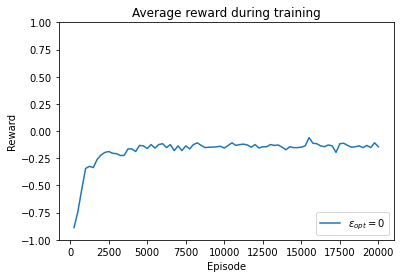

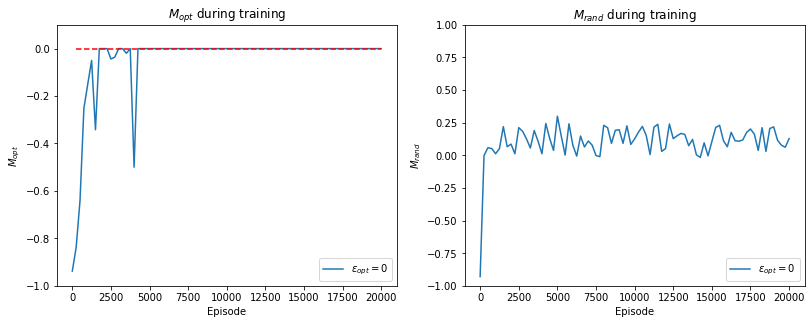

In [32]:
plot_epsilon_opt = vec_epsilon_opt
plot_stats(stats_dict_epsilon_opt, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=save_figs)

### 2.2 Learning by self-practice

## Deep Q-Learning